# Set up

In [1]:
import os
import re
import warnings
from pathlib import Path
from typing import Any, Dict, Iterable, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes

sns.set_style("whitegrid")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


def read_result_file(path: Path, dataset: str) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    model_name = Path(path).stem[len(dataset) + 1 :]

    results_train_only = {
        "feature_type": [],
        "emb": [],
        "cas": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
    }
    results_train_valid = {
        "feature_type": [],
        "emb": [],
        "cas": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
    }
    with open(path) as f:
        # For avoiding duplicate rows for "None" CaS.
        train_only_index_set = set()
        train_valid_index_set = set()
        for line in f:
            match = re.search(
                r"TrainACC: ([0-9\.]+)(?:[^,]+), ValACC: ([0-9\.]+)(?:[^,]+), TestACC: ([0-9\.]+)",
                line,
            )
            if "# Train only" in line:
                results_dict = results_train_only
                index_set = train_only_index_set
            elif "# Train and valid" in line:
                results_dict = results_train_valid
                index_set = train_valid_index_set
            if match:
                train_acc, val_acc, test_acc = map(
                    lambda x: float(x) * 100, match.groups()
                )
                groups = re.search(r"\[(.+?)\]", line).group(1).split("+")
                emb = "None"
                cas = "None"
                if model_name == "none":
                    if len(groups) == 2:
                        _, feature_type = groups
                    else:
                        _, feature_type, cas = groups
                elif "_" in model_name:
                    if len(groups) == 4:
                        _, _, feature_type, emb = groups
                    else:
                        _, _, feature_type, emb, cas = groups
                else:
                    if len(groups) == 3:
                        _, _, feature_type = groups
                    else:
                        _, _, feature_type, cas = groups
                index = (feature_type, emb, cas)
                if index in index_set:
                    continue
                cas = "CaS" if cas == "S" else cas
                index_set.add(index)
                results_dict["feature_type"].append(feature_type)
                results_dict["emb"].append(emb)
                results_dict["cas"].append(cas)
                results_dict["train_acc"].append(train_acc)
                results_dict["val_acc"].append(val_acc)
                results_dict["test_acc"].append(test_acc)

    count = len(results_train_only["feature_type"])
    results_train_only["model_name"] = [model_name] * count
    results_train_only["dataset"] = [dataset] * count
    count = len(results_train_valid["feature_type"])
    results_train_valid["model_name"] = [model_name] * count
    results_train_valid["dataset"] = [dataset] * count
    return results_train_only, results_train_valid


def read_result_dir(result_dir: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    dataset_list = [
        dataset
        for dataset in os.listdir(result_dir)
        if os.path.isdir(result_dir / dataset)
    ]
    train_only_df = pd.DataFrame()
    train_valid_df = pd.DataFrame()
    for dataset in dataset_list:
        dataset_path = result_dir / dataset
        file_list = [
            dataset_path / fname
            for fname in os.listdir(dataset_path)
            if fname.endswith(".txt")
        ]
        for f in file_list:
            train_only_new_df, train_valid_new_df = read_result_file(f, dataset)
            train_only_df = pd.concat([train_only_df, pd.DataFrame(train_only_new_df)])
            train_valid_df = pd.concat(
                [train_valid_df, pd.DataFrame(train_valid_new_df)]
            )
    train_only_df = train_only_df.set_index(
        ["dataset", "model_name", "feature_type", "emb", "cas"]
    )
    train_valid_df = train_valid_df.set_index(
        ["dataset", "model_name", "feature_type", "emb", "cas"]
    )
    return train_only_df, train_valid_df


def reorder_result_df(df: pd.DataFrame) -> pd.DataFrame:
    """Reorders the result data frame.

    Parameters
    ----------
    df : pd.DataFrame
        The result data frame. The data frame must have the following multi-level index:
        ["dataset", "model_name", "feature_type", "emb", "cas"]
    """
    return df.loc[
        ["arxiv_2023", "ogbn-arxiv", "cora", "pubmed"],
        ["mlp", "mlp_node2vec", "gcn", "sage", "revgat", "none"],
        ["TA", "P", "E", "Ensemble"],
        :,
        ["None", "CaS", "ReCaS"],
    ]


def select_from_validation(result_df: pd.DataFrame) -> pd.DataFrame:
    """Selects the best method in the result data frame from validation accuracy.

    Parameters
    ----------
    result_df : pd.DataFrame
        The result data frame.
    """
    result_df: pd.DataFrame = reorder_result_df(result_df)
    tmp_df = result_df.reset_index("cas")
    selected_df = pd.DataFrame()
    for index in tmp_df.index.unique():
        loc_df: pd.DataFrame = tmp_df.loc[index]
        cas_df: pd.DataFrame = loc_df[loc_df["cas"] != "None"]
        no_cas_df: pd.DataFrame = loc_df[loc_df["cas"] == "None"]
        cas_df = cas_df.set_index("cas", append=True)
        no_cas_df = no_cas_df.set_index("cas", append=True)
        cas_df = cas_df.loc[[cas_df["val_acc"].idxmax()]]
        selected_df = pd.concat([selected_df, no_cas_df, cas_df])
    return selected_df.sort_index()


def display_df(df: pd.DataFrame):
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(df)

# Separate CaS and ReCaS

In [2]:
train_only_df, train_valid_df = read_result_dir(Path("results_saved_sep"))

In [3]:
display_df(reorder_result_df(train_only_df))

train_acc  val_acc  \
dataset    model_name   feature_type emb      cas                         
arxiv_2023 mlp          TA           None     None       89.92    77.68   
                                              CaS        99.60    78.22   
                                              ReCaS     100.00    78.34   
                        P            None     None       77.71    75.63   
                                              CaS        99.41    76.13   
                                              ReCaS     100.00    76.51   
                        E            None     None       84.63    77.27   
                                              CaS        99.99    77.69   
                                              ReCaS      99.99    77.98   
                        Ensemble     None     None       87.40    79.42   
                                              CaS       100.00    79.60   
                                              ReCaS     100.00    79.97   
           mlp_node2vec TA           node2vec None       90.77    77.68   
                                              CaS       100.00    78.17   
                                              ReCaS     100.00    77.94   
                        P            node2vec None       79.01    75.40   
                                              CaS       100.00    75.83   
                                              ReCaS     100.00    76.21   
                        E            node2vec None       86.80    77.25   
                                              CaS       100.00    77.58   
                                              ReCaS      99.99    77.79   
                        Ensemble     node2vec None       88.68    79.43   
                                              CaS       100.00    79.93   
                                              ReCaS     100.00    79.86   
           gcn          TA           None     None       86.18    75.46   
                                              CaS       100.00    75.77   
                                              ReCaS     100.00    75.68   
                        P            None     None       76.95    73.00   
                                              CaS        98.50    73.84   
                                              ReCaS     100.00    73.83   
                        E            None     None       82.27    75.25   
                                              CaS        99.57    75.81   
                                              ReCaS      99.96    75.47   
                        Ensemble     None     None       85.14    77.15   
                                              CaS       100.00    77.38   
                                              ReCaS     100.00    77.34   
           sage         TA           None     None       89.13    77.47   
                                              CaS        99.34    77.97   
                                              ReCaS     100.00    78.00   
                        P            None     None       79.44    74.90   
                                              CaS        99.99    75.07   
                                              ReCaS     100.00    75.49   
                        E            None     None       84.97    77.35   
                                              CaS        99.09    77.91   
                                              ReCaS      99.99    77.85   
                        Ensemble     None     None       87.97    79.49   
                                              CaS        99.98    79.61   
                                              ReCaS     100.00    79.67   
           revgat       TA           None     None       88.96    78.17   
                                              CaS       100.00    78.51   
                                              ReCaS     100.00    78.41   
                        P            None     None       80.31    76.39   
   

In [4]:
display_df(reorder_result_df(train_valid_df))

train_acc  val_acc  \
dataset    model_name   feature_type emb      cas                         
arxiv_2023 mlp          TA           None     None       89.92    77.68   
                                              CaS        99.58    99.54   
                                              ReCaS     100.00   100.00   
                        P            None     None       77.71    75.63   
                                              CaS        99.30    99.25   
                                              ReCaS     100.00    99.99   
                        E            None     None       84.63    77.27   
                                              CaS        99.99    99.98   
                                              ReCaS      99.99    99.99   
                        Ensemble     None     None       87.40    79.42   
                                              CaS       100.00   100.00   
                                              ReCaS     100.00   100.00   
           mlp_node2vec TA           node2vec None       90.77    77.68   
                                              CaS       100.00    99.99   
                                              ReCaS     100.00    99.99   
                        P            node2vec None       79.01    75.40   
                                              CaS       100.00    99.99   
                                              ReCaS     100.00   100.00   
                        E            node2vec None       86.80    77.25   
                                              CaS       100.00    99.99   
                                              ReCaS      99.99    99.99   
                        Ensemble     node2vec None       88.68    79.43   
                                              CaS       100.00   100.00   
                                              ReCaS     100.00    99.99   
           gcn          TA           None     None       86.18    75.46   
                                              CaS       100.00   100.00   
                                              ReCaS     100.00   100.00   
                        P            None     None       76.95    73.00   
                                              CaS        98.41    98.39   
                                              ReCaS     100.00   100.00   
                        E            None     None       82.27    75.25   
                                              CaS        99.56    99.50   
                                              ReCaS      99.92    99.91   
                        Ensemble     None     None       85.14    77.15   
                                              CaS       100.00   100.00   
                                              ReCaS     100.00   100.00   
           sage         TA           None     None       89.13    77.47   
                                              CaS        99.31    99.32   
                                              ReCaS     100.00   100.00   
                        P            None     None       79.44    74.90   
                                              CaS        99.99    99.98   
                                              ReCaS     100.00   100.00   
                        E            None     None       84.97    77.35   
                                              CaS        99.05    99.06   
                                              ReCaS      99.99    99.99   
                        Ensemble     None     None       87.97    79.49   
                                              CaS        99.98    99.98   
                                              ReCaS      99.99    99.99   
           revgat       TA           None     None       88.96    78.17   
                                              CaS       100.00   100.00   
                                              ReCaS     100.00   100.00   
                        P            None     None       80.31    76.39   
   

## Select the best model based on validation accuracy

In [5]:
display_df(select_from_validation(train_only_df))

train_acc  val_acc  \
dataset    model_name   feature_type emb      cas                         
arxiv_2023 gcn          E            None     CaS        99.57    75.81   
                                              None       82.27    75.25   
                        Ensemble     None     CaS       100.00    77.38   
                                              None       85.14    77.15   
                        P            None     CaS        98.50    73.84   
                                              None       76.95    73.00   
                        TA           None     CaS       100.00    75.77   
                                              None       86.18    75.46   
           mlp          E            None     None       84.63    77.27   
                                              ReCaS      99.99    77.98   
                        Ensemble     None     None       87.40    79.42   
                                              ReCaS     100.00    79.97   
                        P            None     None       77.71    75.63   
                                              ReCaS     100.00    76.51   
                        TA           None     None       89.92    77.68   
                                              ReCaS     100.00    78.34   
           mlp_node2vec E            node2vec None       86.80    77.25   
                                              ReCaS      99.99    77.79   
                        Ensemble     node2vec CaS       100.00    79.93   
                                              None       88.68    79.43   
                        P            node2vec None       79.01    75.40   
                                              ReCaS     100.00    76.21   
                        TA           node2vec CaS       100.00    78.17   
                                              None       90.77    77.68   
           none         E            None     None       83.33    77.91   
                                              ReCaS     100.00    78.65   
                        Ensemble     None     None       86.46    79.79   
                                              ReCaS     100.00    80.21   
                        P            None     CaS        99.99    73.84   
                                              None       73.47    73.45   
                        TA           None     CaS       100.00    77.81   
                                              None       86.74    77.28   
           revgat       E            None     None       84.08    77.92   
                                              ReCaS      99.99    78.14   
                        Ensemble     None     None       87.60    79.94   
                                              ReCaS     100.00    80.09   
                        P            None     None       80.31    76.39   
                                              ReCaS     100.00    76.83   
                        TA           None     CaS       100.00    78.51   
                                              None       88.96    78.17   
           sage         E            None     CaS        99.09    77.91   
                                              None       84.97    77.35   
                        Ensemble     None     None       87.97    79.49   
                                              ReCaS     100.00    79.67   
                        P            None     None       79.44    74.90   
                                              ReCaS     100.00    75.49   
                        TA           None     None       89.13    77.47   
                                              ReCaS     100.00    78.00   
cora       gcn          E            None     CaS        99.98    86.58   
                                              None       92.15    86.76   
                        Ensemble     None     None       95.07    86.35   
                                              ReCaS      99.98    86.39   
   

In [6]:
tmp_df = train_valid_df.copy()
tmp_df["val_acc"] = train_only_df["val_acc"]
display_df(select_from_validation(tmp_df))

train_acc  val_acc  \
dataset    model_name   feature_type emb      cas                         
arxiv_2023 gcn          E            None     CaS        99.56    75.81   
                                              None       82.27    75.25   
                        Ensemble     None     CaS       100.00    77.38   
                                              None       85.14    77.15   
                        P            None     CaS        98.41    73.84   
                                              None       76.95    73.00   
                        TA           None     CaS       100.00    75.77   
                                              None       86.18    75.46   
           mlp          E            None     None       84.63    77.27   
                                              ReCaS      99.99    77.98   
                        Ensemble     None     None       87.40    79.42   
                                              ReCaS     100.00    79.97   
                        P            None     None       77.71    75.63   
                                              ReCaS     100.00    76.51   
                        TA           None     None       89.92    77.68   
                                              ReCaS     100.00    78.34   
           mlp_node2vec E            node2vec None       86.80    77.25   
                                              ReCaS      99.99    77.79   
                        Ensemble     node2vec CaS       100.00    79.93   
                                              None       88.68    79.43   
                        P            node2vec None       79.01    75.40   
                                              ReCaS     100.00    76.21   
                        TA           node2vec CaS       100.00    78.17   
                                              None       90.77    77.68   
           none         E            None     None       83.33    77.91   
                                              ReCaS     100.00    78.65   
                        Ensemble     None     None       86.46    79.79   
                                              ReCaS     100.00    80.21   
                        P            None     CaS        99.99    73.84   
                                              None       73.47    73.45   
                        TA           None     CaS       100.00    77.81   
                                              None       86.74    77.28   
           revgat       E            None     None       84.08    77.92   
                                              ReCaS      99.99    78.14   
                        Ensemble     None     None       87.60    79.94   
                                              ReCaS     100.00    80.09   
                        P            None     None       80.31    76.39   
                                              ReCaS     100.00    76.83   
                        TA           None     CaS       100.00    78.51   
                                              None       88.96    78.17   
           sage         E            None     CaS        99.05    77.91   
                                              None       84.97    77.35   
                        Ensemble     None     None       87.97    79.49   
                                              ReCaS      99.99    79.67   
                        P            None     None       79.44    74.90   
                                              ReCaS     100.00    75.49   
                        TA           None     None       89.13    77.47   
                                              ReCaS     100.00    78.00   
cora       gcn          E            None     CaS       100.00    86.58   
                                              None       92.15    86.76   
                        Ensemble     None     None       95.07    86.35   
                                              ReCaS     100.00    86.39   
   

# Mixing CaS and ReCaS

In [7]:
train_only_df, train_valid_df = read_result_dir(Path("results_saved_mixed"))

In [8]:
display_df(reorder_result_df(train_only_df))

train_acc  val_acc  \
dataset    model_name   feature_type emb      cas                         
arxiv_2023 mlp          TA           None     None       89.92    77.68   
                                              CaS        99.60    78.22   
                                              ReCaS     100.00    78.20   
                        P            None     None       77.71    75.63   
                                              CaS        99.41    76.13   
                                              ReCaS      99.67    76.50   
                        E            None     None       84.63    77.27   
                                              CaS        99.99    77.69   
                                              ReCaS      99.96    77.91   
                        Ensemble     None     None       87.40    79.42   
                                              CaS       100.00    79.60   
                                              ReCaS     100.00    79.86   
           mlp_node2vec TA           node2vec None       90.77    77.68   
                                              CaS       100.00    78.17   
                                              ReCaS     100.00    78.13   
                        P            node2vec None       79.01    75.40   
                                              CaS       100.00    75.83   
                                              ReCaS     100.00    76.22   
                        E            node2vec None       86.80    77.25   
                                              CaS       100.00    77.58   
                                              ReCaS     100.00    77.70   
                        Ensemble     node2vec None       88.68    79.43   
                                              CaS       100.00    79.93   
                                              ReCaS     100.00    79.73   
           gcn          TA           None     None       86.18    75.46   
                                              CaS       100.00    75.77   
                                              ReCaS      99.84    75.71   
                        P            None     None       76.95    73.00   
                                              CaS        98.50    73.84   
                                              ReCaS      99.96    73.49   
                        E            None     None       82.27    75.25   
                                              CaS        99.57    75.81   
                                              ReCaS      99.79    75.94   
                        Ensemble     None     None       85.14    77.15   
                                              CaS       100.00    77.38   
                                              ReCaS      99.98    77.46   
           sage         TA           None     None       89.13    77.47   
                                              CaS        99.34    77.97   
                                              ReCaS     100.00    78.00   
                        P            None     None       79.44    74.90   
                                              CaS        99.99    75.07   
                                              ReCaS     100.00    75.56   
                        E            None     None       84.97    77.35   
                                              CaS        99.09    77.91   
                                              ReCaS     100.00    77.67   
                        Ensemble     None     None       87.97    79.49   
                                              CaS        99.98    79.61   
                                              ReCaS     100.00    79.62   
           revgat       TA           None     None       88.96    78.17   
                                              CaS       100.00    78.51   
                                              ReCaS     100.00    78.34   
                        P            None     None       80.31    76.39   
   

In [9]:
display_df(reorder_result_df(train_valid_df))

train_acc  val_acc  \
dataset    model_name   feature_type emb      cas                         
arxiv_2023 mlp          TA           None     None       89.92    77.68   
                                              CaS        99.58    99.54   
                                              ReCaS     100.00   100.00   
                        P            None     None       77.71    75.63   
                                              CaS        99.30    99.25   
                                              ReCaS      99.64    99.61   
                        E            None     None       84.63    77.27   
                                              CaS        99.99    99.98   
                                              ReCaS      99.96    99.95   
                        Ensemble     None     None       87.40    79.42   
                                              CaS       100.00   100.00   
                                              ReCaS     100.00   100.00   
           mlp_node2vec TA           node2vec None       90.77    77.68   
                                              CaS       100.00    99.99   
                                              ReCaS     100.00   100.00   
                        P            node2vec None       79.01    75.40   
                                              CaS       100.00    99.99   
                                              ReCaS     100.00   100.00   
                        E            node2vec None       86.80    77.25   
                                              CaS       100.00    99.99   
                                              ReCaS     100.00   100.00   
                        Ensemble     node2vec None       88.68    79.43   
                                              CaS       100.00   100.00   
                                              ReCaS     100.00   100.00   
           gcn          TA           None     None       86.18    75.46   
                                              CaS       100.00   100.00   
                                              ReCaS      99.83    99.83   
                        P            None     None       76.95    73.00   
                                              CaS        98.41    98.39   
                                              ReCaS      99.96    99.93   
                        E            None     None       82.27    75.25   
                                              CaS        99.56    99.50   
                                              ReCaS      99.77    99.73   
                        Ensemble     None     None       85.14    77.15   
                                              CaS       100.00   100.00   
                                              ReCaS      99.98    99.98   
           sage         TA           None     None       89.13    77.47   
                                              CaS        99.31    99.32   
                                              ReCaS     100.00   100.00   
                        P            None     None       79.44    74.90   
                                              CaS        99.99    99.98   
                                              ReCaS      99.99    99.99   
                        E            None     None       84.97    77.35   
                                              CaS        99.05    99.06   
                                              ReCaS     100.00   100.00   
                        Ensemble     None     None       87.97    79.49   
                                              CaS        99.98    99.98   
                                              ReCaS     100.00   100.00   
           revgat       TA           None     None       88.96    78.17   
                                              CaS       100.00   100.00   
                                              ReCaS     100.00   100.00   
                        P            None     None       80.31    76.39   
   

In [10]:
display_df(select_from_validation(train_only_df))

train_acc  val_acc  \
dataset    model_name   feature_type emb      cas                         
arxiv_2023 gcn          E            None     None       82.27    75.25   
                                              ReCaS      99.79    75.94   
                        Ensemble     None     None       85.14    77.15   
                                              ReCaS      99.98    77.46   
                        P            None     CaS        98.50    73.84   
                                              None       76.95    73.00   
                        TA           None     CaS       100.00    75.77   
                                              None       86.18    75.46   
           mlp          E            None     None       84.63    77.27   
                                              ReCaS      99.96    77.91   
                        Ensemble     None     None       87.40    79.42   
                                              ReCaS     100.00    79.86   
                        P            None     None       77.71    75.63   
                                              ReCaS      99.67    76.50   
                        TA           None     CaS        99.60    78.22   
                                              None       89.92    77.68   
           mlp_node2vec E            node2vec None       86.80    77.25   
                                              ReCaS     100.00    77.70   
                        Ensemble     node2vec CaS       100.00    79.93   
                                              None       88.68    79.43   
                        P            node2vec None       79.01    75.40   
                                              ReCaS     100.00    76.22   
                        TA           node2vec CaS       100.00    78.17   
                                              None       90.77    77.68   
           none         E            None     None       83.33    77.91   
                                              ReCaS     100.00    78.52   
                        Ensemble     None     None       86.46    79.79   
                                              ReCaS     100.00    80.22   
                        P            None     CaS        99.99    73.84   
                                              None       73.47    73.45   
                        TA           None     None       86.74    77.28   
                                              ReCaS     100.00    77.93   
           revgat       E            None     None       84.08    77.92   
                                              ReCaS     100.00    78.12   
                        Ensemble     None     CaS       100.00    80.08   
                                              None       87.60    79.94   
                        P            None     None       80.31    76.39   
                                              ReCaS      99.99    76.70   
                        TA           None     CaS       100.00    78.51   
                                              None       88.96    78.17   
           sage         E            None     CaS        99.09    77.91   
                                              None       84.97    77.35   
                        Ensemble     None     None       87.97    79.49   
                                              ReCaS     100.00    79.62   
                        P            None     None       79.44    74.90   
                                              ReCaS     100.00    75.56   
                        TA           None     None       89.13    77.47   
                                              ReCaS     100.00    78.00   
cora       gcn          E            None     None       92.15    86.76   
                                              ReCaS      97.80    86.85   
                        Ensemble     None     None       95.07    86.35   
                                              ReCaS      99.98    86.35   
   

In [11]:
tmp_df = train_valid_df.copy()
tmp_df["val_acc"] = train_only_df["val_acc"]
display_df(select_from_validation(tmp_df))

train_acc  val_acc  \
dataset    model_name   feature_type emb      cas                         
arxiv_2023 gcn          E            None     None       82.27    75.25   
                                              ReCaS      99.77    75.94   
                        Ensemble     None     None       85.14    77.15   
                                              ReCaS      99.98    77.46   
                        P            None     CaS        98.41    73.84   
                                              None       76.95    73.00   
                        TA           None     CaS       100.00    75.77   
                                              None       86.18    75.46   
           mlp          E            None     None       84.63    77.27   
                                              ReCaS      99.96    77.91   
                        Ensemble     None     None       87.40    79.42   
                                              ReCaS     100.00    79.86   
                        P            None     None       77.71    75.63   
                                              ReCaS      99.64    76.50   
                        TA           None     CaS        99.58    78.22   
                                              None       89.92    77.68   
           mlp_node2vec E            node2vec None       86.80    77.25   
                                              ReCaS     100.00    77.70   
                        Ensemble     node2vec CaS       100.00    79.93   
                                              None       88.68    79.43   
                        P            node2vec None       79.01    75.40   
                                              ReCaS     100.00    76.22   
                        TA           node2vec CaS       100.00    78.17   
                                              None       90.77    77.68   
           none         E            None     None       83.33    77.91   
                                              ReCaS     100.00    78.52   
                        Ensemble     None     None       86.46    79.79   
                                              ReCaS     100.00    80.22   
                        P            None     CaS        99.99    73.84   
                                              None       73.47    73.45   
                        TA           None     None       86.74    77.28   
                                              ReCaS     100.00    77.93   
           revgat       E            None     None       84.08    77.92   
                                              ReCaS     100.00    78.12   
                        Ensemble     None     CaS       100.00    80.08   
                                              None       87.60    79.94   
                        P            None     None       80.31    76.39   
                                              ReCaS      99.99    76.70   
                        TA           None     CaS       100.00    78.51   
                                              None       88.96    78.17   
           sage         E            None     CaS        99.05    77.91   
                                              None       84.97    77.35   
                        Ensemble     None     None       87.97    79.49   
                                              ReCaS     100.00    79.62   
                        P            None     None       79.44    74.90   
                                              ReCaS      99.99    75.56   
                        TA           None     None       89.13    77.47   
                                              ReCaS     100.00    78.00   
cora       gcn          E            None     None       92.15    86.76   
                                              ReCaS      97.91    86.85   
                        Ensemble     None     None       95.07    86.35   
                                              ReCaS     100.00    86.35   
   

# Create optimal ReCas parameters

In [2]:
import itertools
from pathlib import Path

from core.CaS.cas_params import CaSParams
from core.CaS.recas_params import ReCaSParams

datasets = ["arxiv_2023", "ogbn-arxiv", "cora", "pubmed"]
model_names = ["MLP", "GCN", "SAGE", "RevGAT", "None"]
feature_types = ["TA", "P", "E", "Ensemble"]
embs = ["None", "node2vec"]

cas_params = CaSParams("core/CaS/cas_params.json")
recas_params = ReCaSParams("core/CaS/recas_params_no_cas.json")

In [3]:
result_df, _ = read_result_dir(Path("results_saved_sep"))
selected_df = select_from_validation(result_df)

In [16]:
best_params = ReCaSParams()
for dataset, model_name, feature_type, emb in itertools.product(
    datasets, model_names, feature_types, embs
):
    gnn_name = model_name
    model_name = model_name.lower()
    if emb == "node2vec":
        if model_name == "mlp":
            model_name += "_" + emb
        else:
            continue
    loc_df = selected_df.loc[dataset, model_name, feature_type, emb, :]
    cas = [
        cas_type
        for cas_type in loc_df.index.get_level_values("cas")
        if cas_type != "None"
    ][0]
    if cas == "CaS":
        params = cas_params.get(
            dataset=dataset, gnn_name=gnn_name, feature_type=feature_type, emb=emb
        )
        best_params.add(
            [params],
            dataset=dataset,
            gnn_name=gnn_name,
            feature_type=feature_type,
            emb=emb,
        )
    else:
        params = recas_params.get(
            dataset=dataset, gnn_name=gnn_name, feature_type=feature_type, emb=emb
        )
        best_params.add(
            params,
            dataset=dataset,
            gnn_name=gnn_name,
            feature_type=feature_type,
            emb=emb,
        )
best_params.save("core/CaS/recas_params_default.json")

# Plot results

In [12]:
class GridPlotter:
    nrows: int
    ncols: int
    tight_layout: bool
    kwargs: Dict[str, Any]

    _counter: int
    _axs: Optional[Union[Axes, np.ndarray]]
    _fig: Optional[plt.Figure]

    def __init__(
        self, nrows: int = 1, ncols: int = 1, tight_layout: bool = True, **kwargs
    ):
        if nrows <= 0 and ncols <= 0:
            raise ValueError("Either nrows or ncols must be positive.")
        self.nrows = nrows
        self.ncols = ncols
        self.tight_layout = tight_layout
        self.kwargs = kwargs

        self._counter = 0
        self._axs = None
        self._fig = None

    def iteraxs(self, count: int = -1) -> Iterable[Axes]:
        self.reset()
        nrows, ncols = self.get_grid_shape(count)
        fig, axs = plt.subplots(nrows, ncols, **self.kwargs)
        self._fig, self._axs = fig, axs
        if self.tight_layout:
            fig.tight_layout()

        if isinstance(axs, np.ndarray):
            if axs.ndim == 1:
                for i in range(max(ncols, nrows)):
                    if self._counter == count:
                        break
                    self._counter += 1
                    yield axs[i]
            else:
                for i in range(nrows):
                    for j in range(ncols):
                        if self._counter == count:
                            break
                        self._counter += 1
                        yield axs[i, j]
        else:
            self._counter += 1
            yield axs

    def show(self):
        if self._fig is None:
            raise ValueError("No figure to save.")
        self.finish()
        self._fig.show()
        self.reset()

    def savefig(self, path: Path):
        if self._fig is None:
            raise ValueError("No figure to save.")
        self.finish()
        self._fig.savefig(path)

    def finish(self):
        if self._axs is None or self._fig is None:
            return
        axs = self._axs
        if isinstance(axs, np.ndarray):
            if axs.ndim == 1:
                for ax in axs[self._counter :]:
                    ax.axis("off")
            else:
                start_row = self._counter // axs.shape[1]
                start_col = self._counter % axs.shape[1]
                for i in range(start_row, axs.shape[0]):
                    if i == start_row:
                        for j in range(start_col, axs.shape[1]):
                            axs[i, j].axis("off")
                    else:
                        for j in range(axs.shape[1]):
                            axs[i, j].axis("off")
        else:
            if self._counter == 0:
                axs.axis("off")

    def reset(self):
        self._counter = 0
        self._axs = None
        self._fig = None

    def get_grid_shape(self, count: int = -1) -> Tuple[int, int]:
        if self.nrows <= 0:
            if count < 0:
                raise ValueError("count must not be negative.")
            nrows = int(np.ceil(count / self.ncols))
        else:
            nrows = self.nrows
        if self.ncols <= 0:
            if count < 0:
                raise ValueError("count must not be negative.")
            ncols = int(np.ceil(count / self.nrows))
        else:
            ncols = self.ncols
        return nrows, ncols

    def update(self, **kwargs):
        self.kwargs.update(kwargs)

pubmed


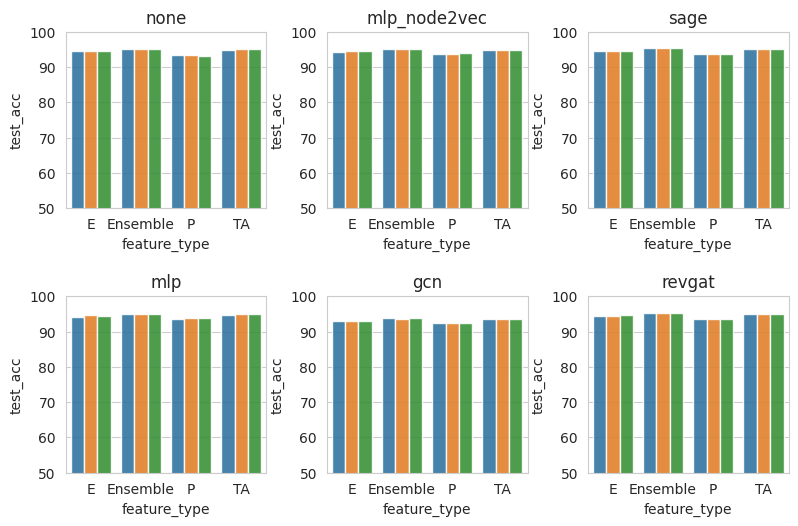

arxiv_2023


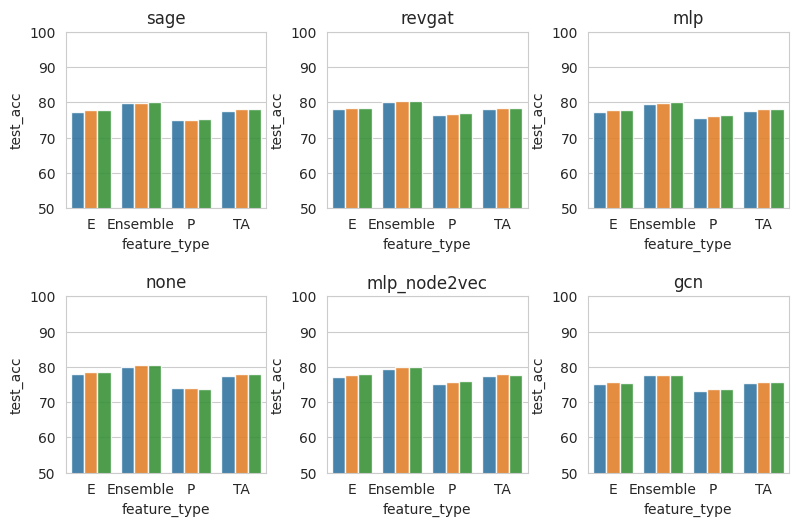

ogbn-arxiv


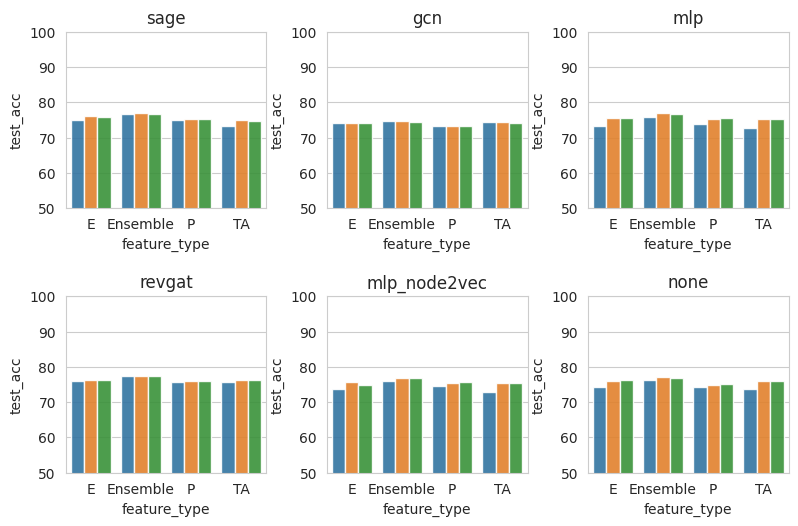

cora


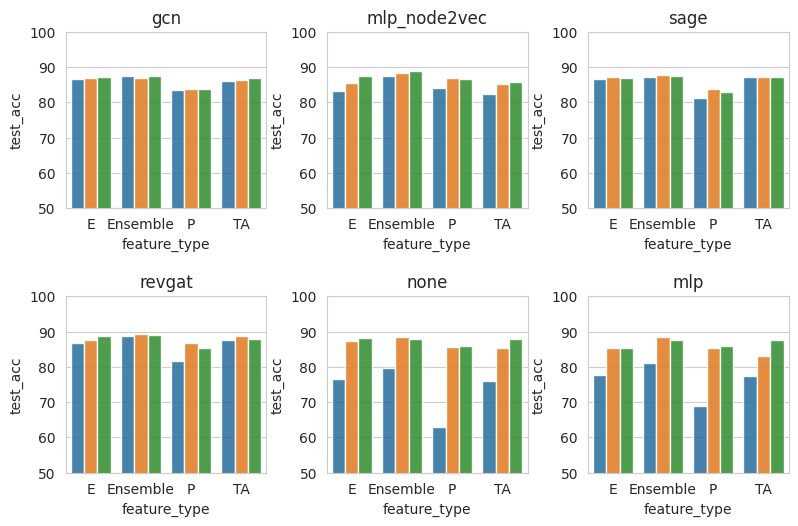

In [13]:
result_dir = Path("results_saved_sep")
train_only_df, _ = read_result_dir(result_dir)
dataset_list = train_only_df.index.get_level_values("dataset").unique()
for dataset in dataset_list:
    plotter = GridPlotter(nrows=-1, ncols=3, figsize=(8, 5), tight_layout=True)
    df = train_only_df.loc[dataset].reset_index()
    df = df[df["cas"].isin(["None", "CaS", "ReCaS"])]
    model_names = df["model_name"].unique()
    for model_name, ax in zip(model_names, plotter.iteraxs(len(model_names))):
        sns.barplot(
            df[df["model_name"] == model_name],
            x="feature_type",
            y="test_acc",
            hue="cas",
            ax=ax,
            alpha=0.9,
            legend=False,
        )
        ax.set_ylim(50, 100)
        ax.set_title(model_name)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    print(dataset)
    plotter.show()
    plt.show()